<a href="https://colab.research.google.com/github/SeanSDarcy2001/kanoldLab/blob/main/CNNforTones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import mat73
import numpy as np
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [2]:
class NeuralDataset(Dataset) :
  def __init__(self, frames, tones, transforms = None):
    self.img_labels = tones
    self.frames = frames
    self.transform = transforms
  
  def __len__(self):
    return len(self.img_labels[0, :])

  def __getitem__(self, idx):
    frame = torch.unsqueeze(self.frames[:, :, idx], 0)
    labels = self.img_labels[:, idx]
    return frame, labels

In [3]:
print("Loading data...")

data = mat73.loadmat('data_unmixed_and_averaged.mat')
data = data['data_unmixed']
windows = np.zeros([330, 330, 960])
tones = np.zeros([16, 960])

k = 0
for i in range(16) :
    for j in range(2) :
        for l in range(30) :
            windows[:, :, k] = data[:, :, l, i, j]
            one_hot = np.zeros(16)
            one_hot[i] = 1
            tones[:, k] = one_hot
            k += 1

print("Input shape:", windows[:, :, 0].shape)

transform = transforms.Resize((150,150))

trainFraction = .8
sample = np.random.uniform(size = 960) < trainFraction
xtrain = torch.from_numpy(windows[:, :, sample])
ytrain = torch.from_numpy(tones[:, sample])
xtest = torch.from_numpy(windows[:, :, ~sample])
ytest = torch.from_numpy(tones[:, ~sample])

#print(len(xtest[1, 1, :]))

print("Training dataset size:", len(xtrain[1, 1, :]), "Testing dataset size:", len(xtest[1, 1, :]))

train_toneDataset = NeuralDataset(xtrain, ytrain, transforms = transform)
test_toneDataset = NeuralDataset(xtest, ytest, transforms= transform)

training_loader = DataLoader(train_toneDataset, batch_size=3, shuffle=True, num_workers=2)
testing_loader = DataLoader(test_toneDataset, batch_size=1, shuffle=True, num_workers=2)

class Classifier(nn.Module) :
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(1, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2),
            
            nn.Flatten(),
            nn.Linear(430336,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,16)
        )
    def forward(self, x):
        return self.network(x) 


trainLoss = []
valLoss = []
trainAcc = []
valAcc = []
testAcc = []

model = Classifier()
optimizer =  torch.optim.Adam(model.parameters(), lr = .01, betas = [.9, .999])
loss= torch.nn.CrossEntropyLoss()

if torch.cuda.is_available():
  model.cuda()


def getAcc(gt, out) :
  correct = 0
  wrong = 0
  for i, k in zip(gt, out) :
    if i == k :
      correct += 1
    else :
      wrong += 1
  accuracy = correct / (correct + wrong)
  return accuracy

for epoch in range(50):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    trainOuts = []
    valOuts = []
    epochLossT = []
    epochLossV = []
      
    trainEpochAccs = []
    model.train()
    model = model.float()

    idx = torch.randperm(xtrain.size(2))
    xtrain = xtrain[:, :, idx]
    ytrain = ytrain[:, idx]

    for i, (input, label) in enumerate(training_loader):
        print("Frame", i, "of", len(xtrain[1, 1, :]))
        #print(input.shape)
        #print(label.shape)
        #inputs = xtrain[:, :, i]
        #label = ytrain[:, i]
        #input = torch.unsqueeze(input, 0)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        
        outputs = model(input.float().cuda())
        #print(outputs)
        #print(outputs.shape)
        #print(label)
        #print(label.shape)

        l = loss(outputs, torch.argmax(label.cuda(), dim = 1))
        print("Loss:", l.item())
        epochLossT.append(l.item())
        a = getAcc(torch.argmax(label, dim = 1), torch.argmax(outputs, dim = 1))
        trainEpochAccs.append(a)
        l.backward()
        optimizer.step()

        

    testOuts = []
    testLabels = []
    model.eval()
    for i, (input, label) in enumerate(testing_loader):
        #inputs = xtest[:, :, k]
        #labels = ytest[:, k]
        #input = torch.unsqueeze(input, 0)
        testOut = model(input.float().cuda())
        testOuts.append(torch.argmax(testOut))
        testLabels.append(torch.argmax(label))

    #report stats every epoch
    print("Training Loss:", np.mean(epochLossT))
    trainLoss.append(np.mean(epochLossT))
    print("Validation Loss:", np.mean(epochLossV))
    valLoss.append(np.mean(epochLossV))

    trainingAcc = np.mean(trainEpochAccs)
    testingAcc = getAcc(testLabels, testOuts)
    print("Train Accuracy:", trainingAcc)
    trainAcc.append(trainingAcc)
    print("Test Accuracy:", testingAcc)
    testAcc.append(testingAcc)

print('Finished Training')

plt.figure()
plt.plot(range(50), trainLoss, color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')

plt.figure()
plt.plot(range(50), testAcc, color='darkblue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')


Loading data...
Input shape: (330, 330)
Training dataset size: 744 Testing dataset size: 216
Epoch: 0
Frame 0 of 744
Loss: 2.8940823078155518
Frame 1 of 744
Loss: 4895.86279296875
Frame 2 of 744
Loss: 36779.140625
Frame 3 of 744
Loss: 11437.57421875
Frame 4 of 744
Loss: 511.4212951660156
Frame 5 of 744
Loss: 1249.1456298828125
Frame 6 of 744
Loss: 553.764892578125
Frame 7 of 744
Loss: 802.2243041992188
Frame 8 of 744
Loss: 679.436767578125
Frame 9 of 744
Loss: 732.7804565429688
Frame 10 of 744
Loss: 438.1293640136719
Frame 11 of 744
Loss: 514.3187866210938
Frame 12 of 744
Loss: 252.5225372314453
Frame 13 of 744
Loss: 238.5362548828125
Frame 14 of 744
Loss: 208.86070251464844
Frame 15 of 744
Loss: 224.4539794921875
Frame 16 of 744
Loss: 199.0028533935547
Frame 17 of 744
Loss: 156.97132873535156
Frame 18 of 744
Loss: 137.8588409423828
Frame 19 of 744
Loss: 272.9247741699219
Frame 20 of 744
Loss: 45.676025390625
Frame 21 of 744
Loss: 51.158138275146484
Frame 22 of 744
Loss: 33.40686416625

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Streaming output truncated to the last 5000 lines.
Loss: 2.7516210079193115
Frame 21 of 744
Loss: 2.7177608013153076
Frame 22 of 744
Loss: 2.778850793838501
Frame 23 of 744
Loss: 2.8042240142822266
Frame 24 of 744
Loss: 2.78631591796875
Frame 25 of 744
Loss: 2.7496185302734375
Frame 26 of 744
Loss: 2.765126943588257
Frame 27 of 744
Loss: 2.7998201847076416
Frame 28 of 744
Loss: 2.7614641189575195
Frame 29 of 744
Loss: 2.74633526802063
Frame 30 of 744
Loss: 2.8096072673797607
Frame 31 of 744
Loss: 2.7240846157073975
Frame 32 of 744
Loss: 2.77719783782959
Frame 33 of 744
Loss: 2.8206193447113037
Frame 34 of 744
Loss: 2.765766143798828
Frame 35 of 744
Loss: 2.8101022243499756
Frame 36 of 744
Loss: 2.7876131534576416
Frame 37 of 744
Loss: 2.803056478500366
Frame 38 of 744
Loss: 2.7530853748321533
Frame 39 of 744
Loss: 2.7703802585601807
Frame 40 of 744
Loss: 2.7684268951416016
Frame 41 of 744
Loss: 2.7711360454559326
Frame 42 of 744
Loss: 2.7662456035614014
Frame 43 of 744
Loss: 2.77397251

KeyboardInterrupt: ignored

Text(0.5, 1.0, 'Test Accuracy vs Epoch')

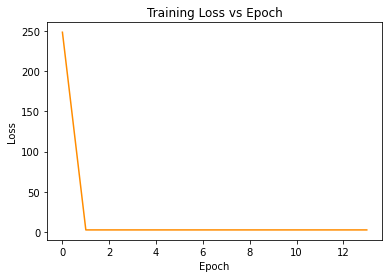

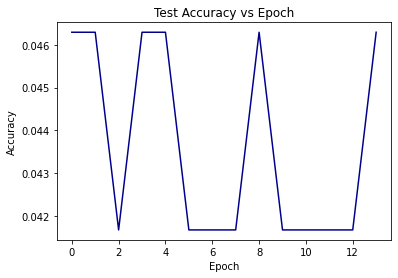

In [8]:
plt.figure()
plt.plot(range(14), trainLoss, color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')

plt.figure()
plt.plot(range(14), testAcc, color='darkblue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy vs Epoch')